# Import libraries

In [1]:
%%capture --no-display
import os, random 
import numpy as np
from simulation import Simulation
from connectome import Connectome
from utility import are_signals_similar

# Init data saving folder:
SAVE_FOLDER = './result/res'
ROOT_FOLDER = os.getcwd()
try:
    os.listdir(SAVE_FOLDER)
except:
    os.mkdir(SAVE_FOLDER)

# Task 1: Simulating sequential auditory inputs in A1

### Initialise and run the simulation in A1_R with 4 different stimulus strength

In [2]:
connectivity_path = ROOT_FOLDER + '/tvb_model_reference/data/macaque/Connectivity/'

connectome = Connectome(connectivity_path)

sim_series1_param = {"root_folder": SAVE_FOLDER,
                     "sim_name": "sim1", #Name of the simulation
                     "connectome_instance": connectome, #Load the connectome to change
                     "rois_dict": {'A1_R': 'Primary auditory cortex'}, #Stimulus Regions
                     "stim_values": [0.001, 0.405, 0.41, 2], # Stimulus strengths
                     "isIntNoise": False}

# Create and init a simulator object
SimSeries1 = Simulation(**sim_series1_param)

# Run the simulation
# SimSeries1.main_simulation_loop() 

### Load and output 4 plots (one for each strimulus strength)

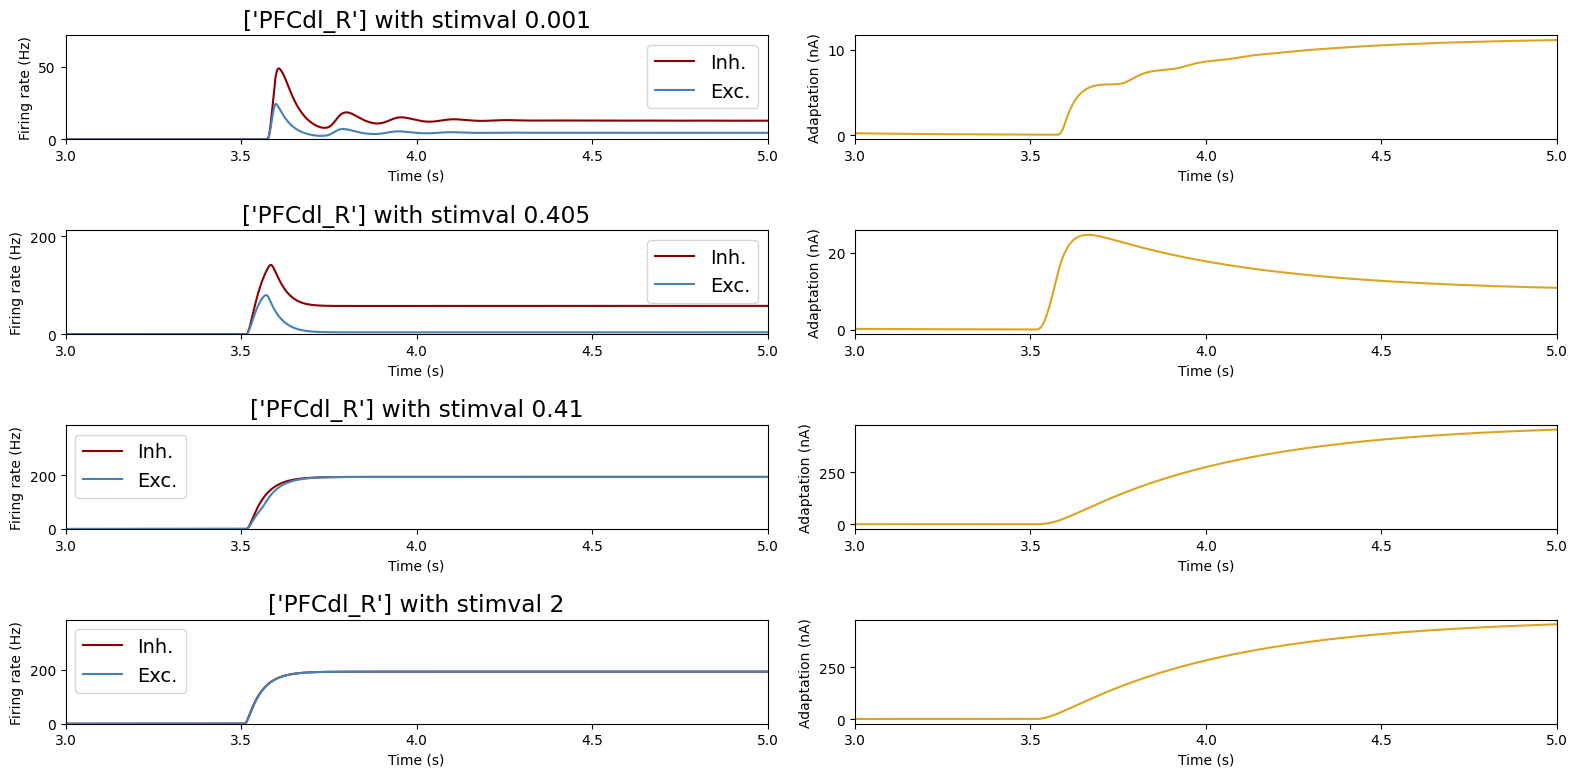

In [3]:
# Load simulation saved results
SimSeries1.load_simulation() 

# PFCdl_R plot from A1
SimSeries1.plot_simulation(['PFCdl_R']) 

# 2) Comparative Analysis of PFCdl Outputs using MSE

This nuanced alteration in neuronal response potentially allows for the categorization of input signals in A1 into two groups: those associated with stimulus values less than or equal to 0.405 and those with stimulus values greater than or equal to 0.41. <br>
These findings present the possibility of developing a thresholding mechanism for signal categorization based on varying stimvals. Therefore, by analyzing the outputted neuronal firing rate in the prefrontal cortex, it may be possible to retroactively determine the initial stimulus value that was utilized in A1.
<br>
<br>
For the purpose of comparing the inhibitory firing rates resulting from two distinct simulations (i.e., simulations with varying stimulus values), we elected to use the Mean Square Error (MSE) algorithm. This algorithm is particularly suited to our study as it quantitatively measures the difference between two continuous variables, thereby enabling us to accurately evaluate the relative impact of differing stimulus values on inhibitory firing rates.

### Compute MSE (Mean Square Error) of each 4 simulations to define a threshold

In [4]:
# signals_dict contains 4 signals each resulted from Sim1 with a different stimval
signals_dict = SimSeries1.get_signals_from_one_region(['PFCdl_R'])
stimvals = sim_series1_param["stim_values"]

signal0 = signals_dict[stimvals[0]] # with stimval = 0.001
signal1 = signals_dict[stimvals[1]] # with stimval = 0.405
signal2 = signals_dict[stimvals[2]] # with stimval = 0.41
signal3 = signals_dict[stimvals[3]] # with stimval = 2

are_signals_similar(signal0, signal1)
are_signals_similar(signal2, signal3)
are_signals_similar(signal1, signal2)
are_signals_similar(signal0, signal3)

MSE: 34.574663777510715
MSE: 2.733403337791166
MSE: 91.21913761853249
MSE: 123.35349977942418


Our analyses led us to identify a Mean Square Error (MSE) value of 60 as an optimal threshold for distinguishing between inhibitory firing rates in the dorsolateral prefrontal cortex (PFCdl) that originate from different stimulus values. This threshold provides a reliable demarcation point, facilitating a clear differentiation of neuronal responses based on their corresponding stimulus inputs.

# 3) Testing: 2 different types of simulation in M1 (i.e Type1 or Type2) whether inputs are similar or not

In this phase of the study, we incorporated a specialized 'press_button' function to simulate the action of the macaque pressing a button. In practical terms, this function initiates a new simulation within a specified target region—our choice being the primary motor cortex (M1)—with a selectable stimulus value.

Subsequently, we designed a 'task_decision' function, which randomly selects two inhibitory firing outputs from the four signals with different stimvalues we have previously simulated in (PFCdl). This function simulates the randomness inherent in the presentation of stimuli S1 and S2. Utilizing the Mean Square Error (MSE)-based threshold, we are then able to differentiate between the outputs corresponding to S1 and S2.

This information is then employed to modulate the stimulus input value in M1, effectively creating two distinct responses in this region—either a simulation of button pressing or a simulation without such an action.

In [5]:
def random_signal_picker(dict_of_signal, verbose = False):
    '''
    Return two time series randomly picked from dict_of_signal.
    
    param dict_of_signal (dict): contains timeseries of inh firing rates as values and their stimval as keys.
    param verbose (bool): True to print verbose.
    '''
    # Select two random stimvals from signals_dict
    stimvals = random.sample(list(dict_of_signal.keys()), 2)
    # Get the time series associated with the selected stimvals
    if verbose : 
        print(f"Signals with stimval = {stimvals[0]} and {stimvals[1]} have been randomly selected")
    return dict_of_signal[stimvals[0]], dict_of_signal[stimvals[1]]


def press_button(stim_region, stimval, plot_taget_area, exp_name = ""):
    '''
    Run a simulation with a given stimulus target region and stimval.
    
    param stim_region (dict): dictionnary of regions of interest where to input the stimulus.
    param stimval (list): list of stimulus strength.
    plot_target_area (str): Name of the target area to plot.
    param exp_name (str): experiment name.
    '''
    button_sim_param = {"root_folder": SAVE_FOLDER,
                        "sim_name": f"sim_temp{exp_name}", #Name of the simulation
                        "connectome_instance": connectome, #Load the surface/connectome to change
                        "rois_dict": stim_region, #Stimulus Regions
                        "stim_values": stimval, # Stimulus strengths
                        "isIntNoise": False}

    # Create and initialize the simulator with M1 as stimulus region
    SimTemp = Simulation(**button_sim_param)
    SimTemp.main_simulation_loop() # Run simulation
    SimTemp.load_simulation() # Load simulation
    SimTemp.plot_simulation(plot_taget_area) # M1 plots


def take_decision(signal1, signal2, threshold = 0):
    '''
    MSE-based thresholder that acts as a decision maker.
    Return either [0.001] or [0.02] whether signal1 and signal2 are similar or not.
    [0.001] and [0.02] corresponds to 2 diff stimvals.
    
    param signal1 ([]): time-serie of inh firing rates with a given a stimval.
    param signal2 ([]): another time-serie of inh firing rates with a given a stimval.
    param thresh (int): MSE-based threshold to differentiate S1 from S2.
    '''
    # Determine stimval in M1 based on time series similarity
    return [0.001] if are_signals_similar(signal1, signal2, threshold) else [0.02]

Signals with stimval = 0.001 and 0.405 have been randomly selected
Stimulus duration: 9.0ms 
Adaptation parameter (b): [5]
Interstimulus duration: [1000000000.0]mS
Areas of interest: ['M1_R']
******************************
||| Stimulus values: 0.001nS
simulation time :1000.0
simulation time :2000.0
simulation time :3000.0
simulation time :4000.0
simulation time :5000.0
Simulation took 61.22 seconds to complete.


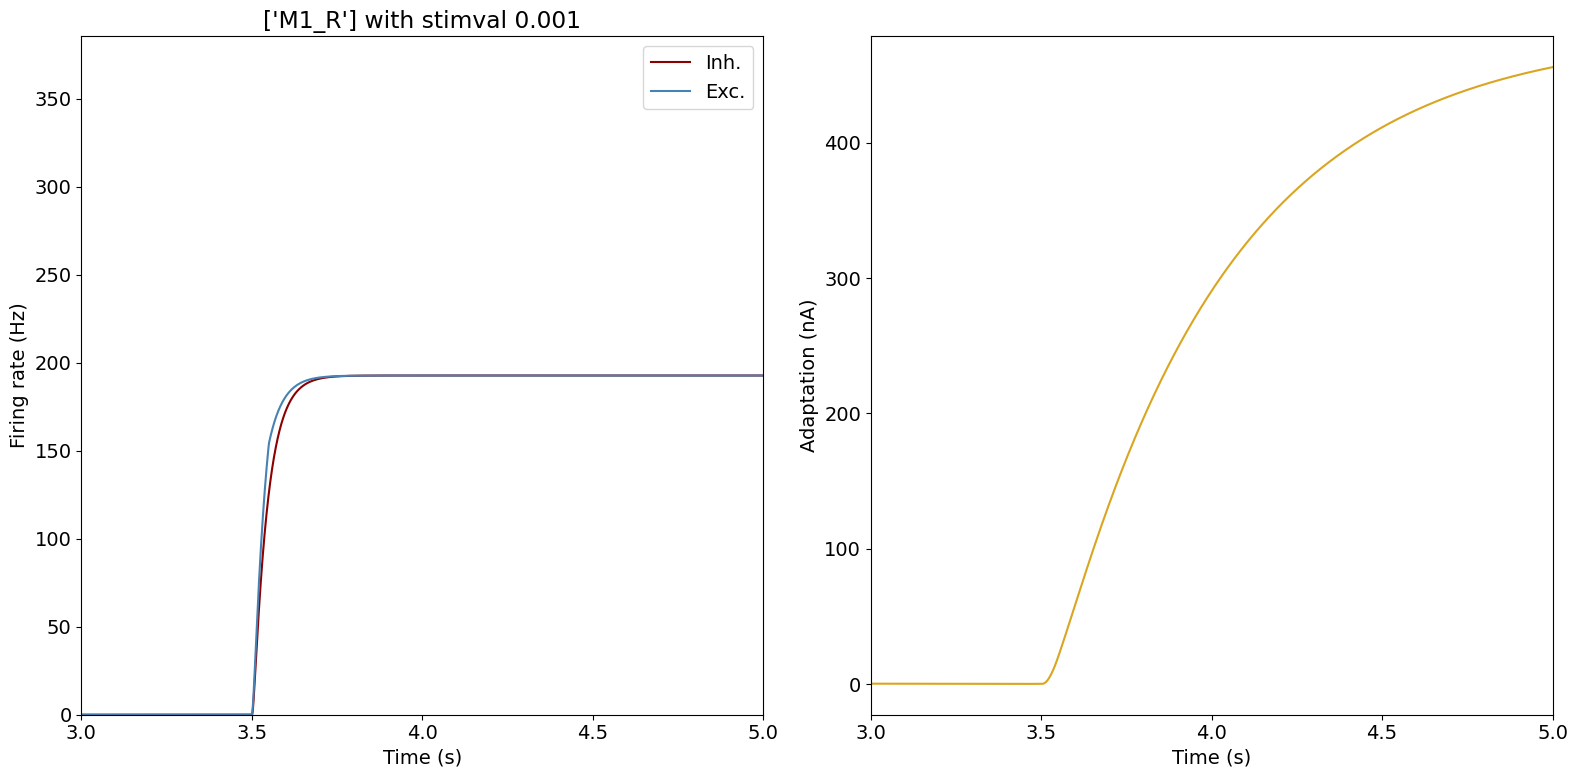

Signals with stimval = 2 and 0.001 have been randomly selected
Stimulus duration: 50ms 
Adaptation parameter (b): [5]
Interstimulus duration: [1000000000.0]mS
Areas of interest: ['M1_R']
******************************
||| Stimulus values: 0.02nS
simulation time :1000.0
simulation time :2000.0
simulation time :3000.0
simulation time :4000.0
simulation time :5000.0
Simulation took 60.70 seconds to complete.


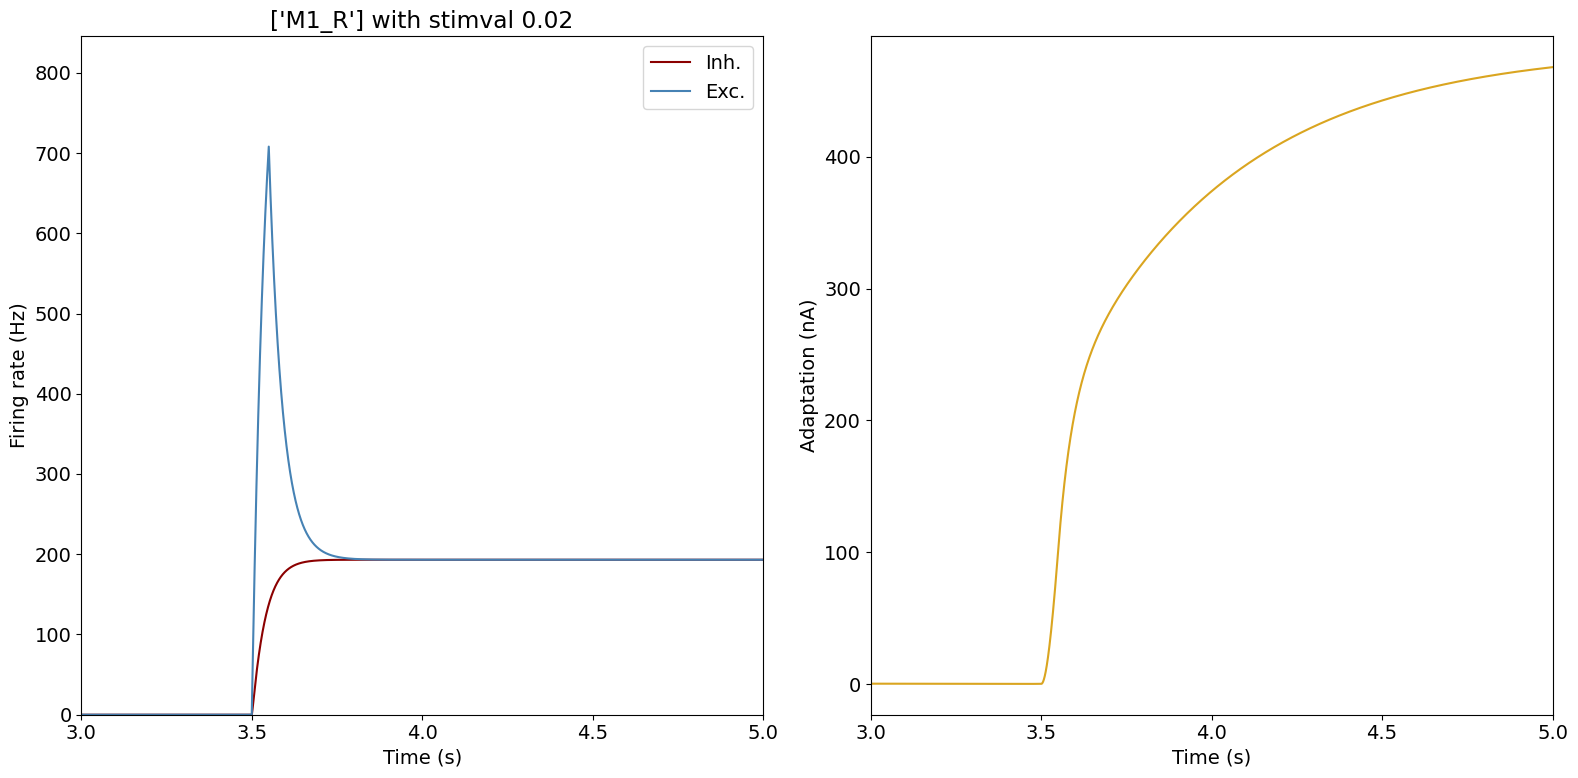

In [6]:
# Define where to apply the stimulus.
motor_stim_region = {'M1_R': 'Primary motor area'} 
plot_area = ["M1_R"]

task_nb = 2 # Run a set of 2 comparison tasks.

for i in range(1, task_nb+1):
    input_signal1, input_signal2 = random_signal_picker(signals_dict, verbose = True)
    stimval_M1 = take_decision(input_signal1, input_signal2, threshold = 60)
    press_button(motor_stim_region, stimval_M1, plot_area, exp_name = str(i))

# Case 2: with 2 cortical cols in A1_R and PFCdl_R

### Edit the connectome to create 2 corticals in the form of [A1_Ra, A1_Rb] and [PFCdl_Ra, PFCdl_Rb] to simulate simultaneous S1 and S2 inputs.

In [7]:
new_connectivity_file_name = "Conn_case2"
new_connectivity_path = ROOT_FOLDER + f'/tvb_model_reference/data/macaque/{new_connectivity_file_name}/'

connectome.duplicate_region('A1_R')
connectome.duplicate_region('PFCdl_R')

# Set Cross-weight to 0 i.e [A1_Ra, PFCdl_Rb] and [A1_Rb, PFCdl_Ra]
connectome.set_weight('A1_Ra', 'PFCdl_Rb', 0)
connectome.set_weight('A1_Rb', 'PFCdl_Ra', 0)

# Save the edited connectome
connectome.save_changes(new_connectivity_path)

### Run simulation at A1_Ra and A1_Rb

In [8]:
new_connectome = Connectome(new_connectivity_path)
sim_series2_param = {"root_folder": SAVE_FOLDER,
                     "sim_name": "sim2", #Name of the simulation
                     "connectome_instance": new_connectome, #Load the surface/connectome to change
                     "rois_dict": {'A1_Ra': 'Primary auditory cortex a',
                                   'A1_Rb': 'Primary auditory cortex b'}, #Stimulus Regions
                     "stim_values": [0.001, 0.405, 0.41, 2], # Stimulus strengths
                     "isIntNoise": False}

# Create and init a simulator object
SimSeries2 = Simulation(**sim_series2_param)

# Run the simulation
# SimSeries2.main_simulation_loop()

In [9]:
# Load results and plot outputs from the two corticals of PFCdl

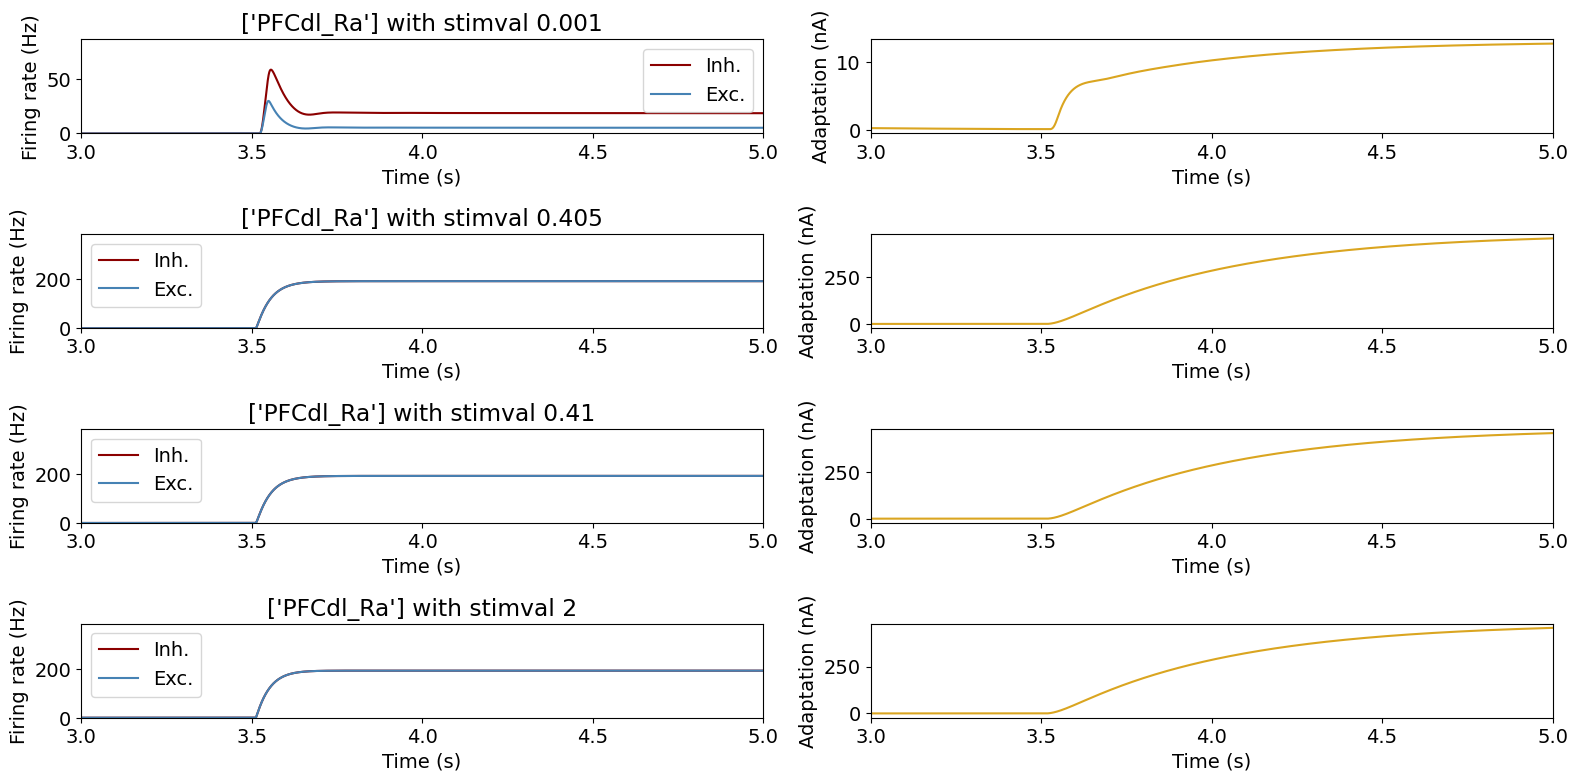

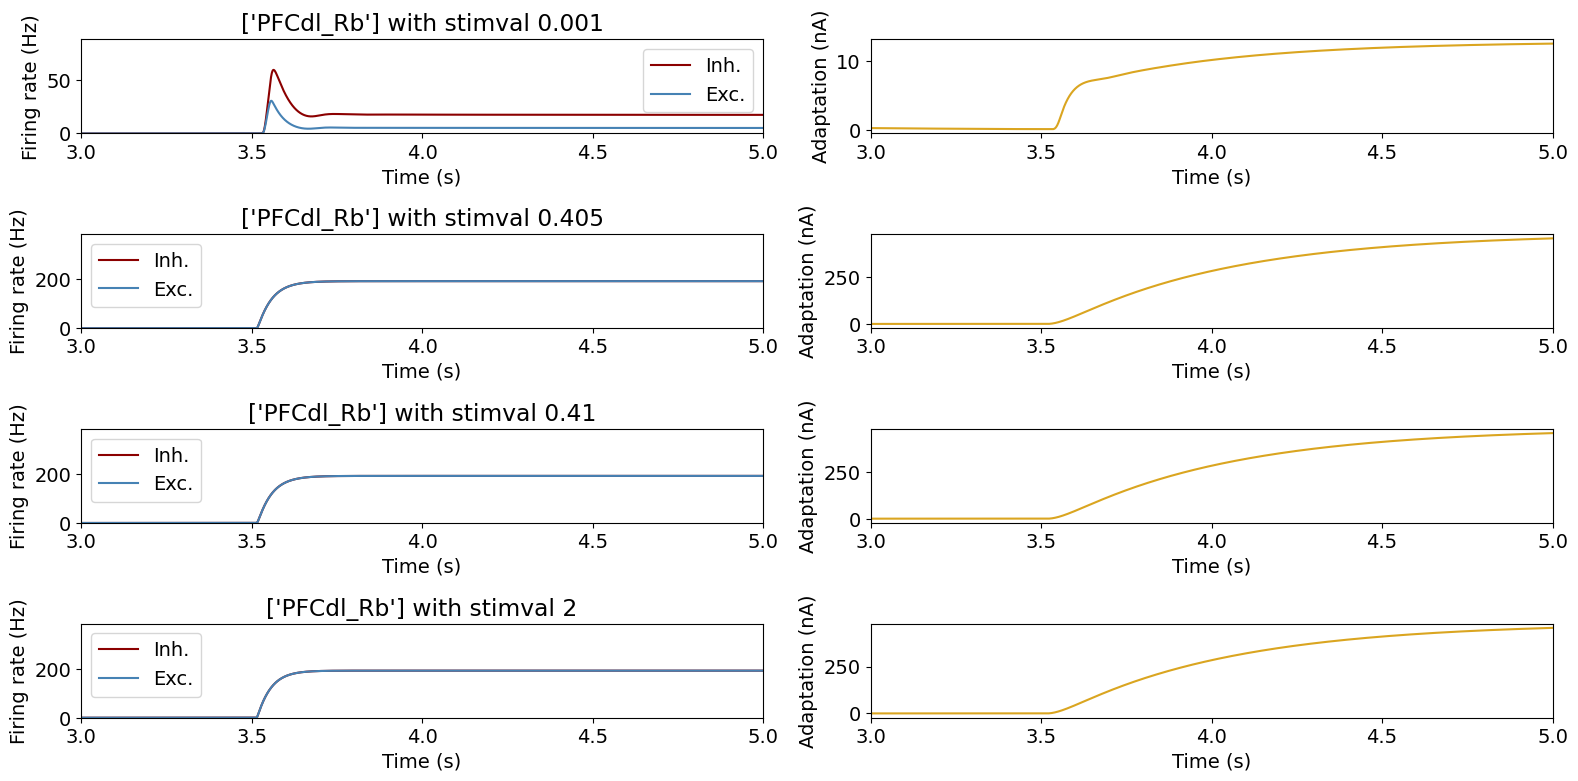

In [10]:
SimSeries2.load_simulation() # Load simulation
SimSeries2.plot_simulation(['PFCdl_Ra'])
SimSeries2.plot_simulation(['PFCdl_Rb'])